# Design Pattern 13: Transfer Learning

> Permite usar um modelo que foi treinado em um grande conjunto de dados similar e adaptá-lo a uma nova tarefa com um conjunto de dados menor.

### Bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

2024-07-10 07:23:12.937625: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 07:23:12.940219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 07:23:12.983537: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 07:23:12.984483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 07:23:13.844287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Transfer Learning

#### Carregar e Pré-processar os Dados

In [2]:
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
base_dir = os.path.join(os.path.dirname(dataset_path), 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Usa o image_dataset_from_directory para carregar as imagens em batches.
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


#### Data Augmentation

In [3]:
# para melhorar a robustez do modelopara melhorar a robustez do modelo
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
])

#### Modelo Pré-Treinado

In [4]:
# Pré-processamento para MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 2. Carregar o Modelo Pré-Treinado
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Congela as camadas e adiciona a camada de saída

In [5]:
# Congelar as camadas do modelo base
base_model.trainable = False

# Camada de pooling global para reduzir a dimensionalidade. Ajuda a evitar overfitting
# Converte os recursos da última camada convolucional em um único vetor de características
global_average_layer = layers.GlobalAveragePooling2D()
dropout_layer = layers.Dropout(0.2)  # Camada de dropout para regularização
prediction_layer = layers.Dense(1)  # Camada de saída

#### Treinamento

In [6]:
# Montar o modelo
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Treinar o Modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 15s 208ms/step - loss: 0.6132 - accuracy: 0.6290 - val_loss: 0.4428 - val_accuracy: 0.7080
Epoch 2/10
63/63 [==============================] - 12s 187ms/step - loss: 0.4764 - accuracy: 0.7285 - val_loss: 0.3328 - val_accuracy: 0.8100
Epoch 3/10
63/63 [==============================] - 13s 200ms/step - loss: 0.3752 - accuracy: 0.8165 - val_loss: 0.2657 - val_accuracy: 0.8700
Epoch 4/10
63/63 [==============================] - 12s 184ms/step - loss: 0.3253 - accuracy: 0.8525 - val_loss: 0.2261 - val_accuracy: 0.8930
Epoch 5/10
63/63 [==============================] - 12s 185ms/step - loss: 0.2892 - accuracy: 0.8650 - val_loss: 0.1932 - val_accuracy: 0.9190
Epoch 6/10
63/63 [==============================] - 11s 179ms/step - loss: 0.2730 - accuracy: 0.8825 - val_loss: 0.1730 - val_accuracy: 0.9300
Epoch 7/10
63/63 [==============================] - 12s 185ms/step - loss: 0.2442 - accuracy: 0.8945 - val_loss: 0.1542 - val_accuracy: 0.9430

#### Avaliar o Modelo

32/32 [==============================] - 4s 110ms/step - loss: 0.1254 - accuracy: 0.9540
Avaliação do modelo - Loss: 0.12536649405956268, Accuracy: 0.9539999961853027


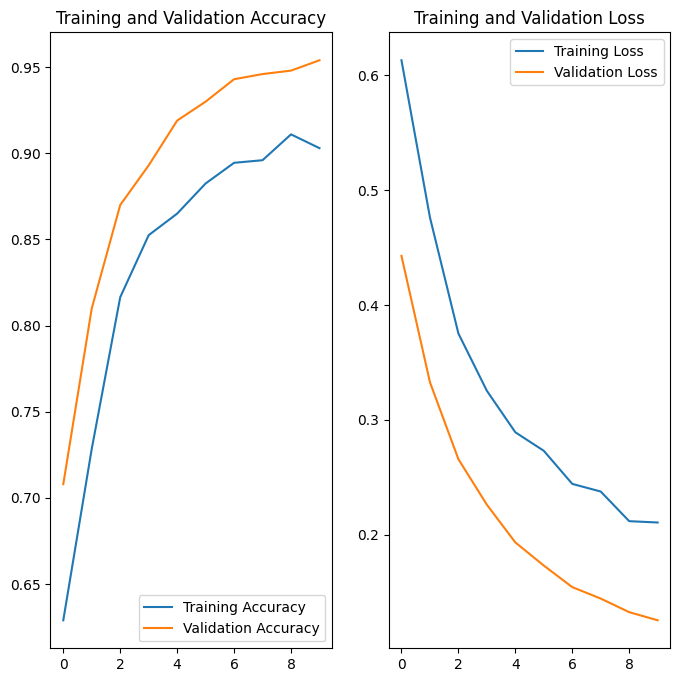

In [7]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Avaliação do modelo - Loss: {loss}, Accuracy: {accuracy}")


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Teste

1/1 [==============================] - 1s 922ms/step


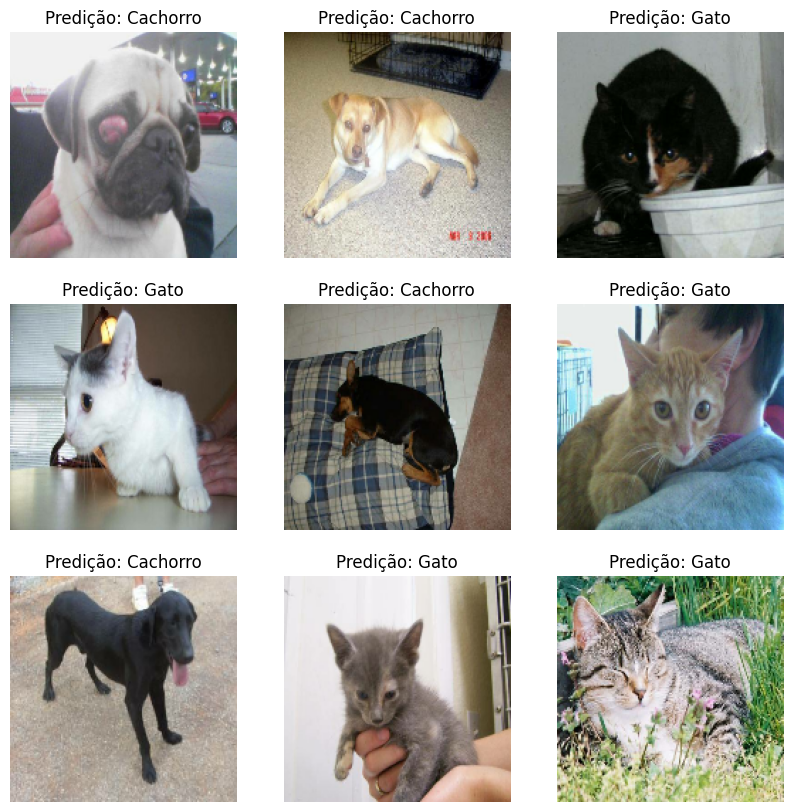

In [8]:
def plot_image_with_prediction(dataset, model):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predictions = tf.nn.sigmoid(predictions)
        predictions = tf.where(predictions < 0.5, 0, 1)
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Predição: {'Cachorro' if predictions[i] == 1 else 'Gato'}")
            plt.axis("off")
    plt.show()

plot_image_with_prediction(validation_dataset, model)